## Testing excitatory synapses 

In [1]:
%matplotlib notebook

import brian2 as b2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import preprocessing

from input_factory import get_step_current
from plot_tools import plot_voltage_and_current_traces

In [2]:
# reversal potential for conductance based synapses
E_exc = 0 * b2.mV
E_inh = -80 * b2.mV

In [3]:
model_eqs_exc = '''
dv/dt = (-gL_exc*(v-v_rest_exc) - w1 - w2 + I)/C_exc : volt

dw1/dt = -w1/tau_w1_exc : amp
dw2/dt = -w2/tau_w2_exc : amp

dvt1/dt = -vt1/tau_vt1_exc : volt
dvt2/dt = -vt2/tau_vt2_exc : volt

vt = v_thresh_exc + vt1 + vt2 : volt
lambda_t = lambda_0*exp((v-vt)/del_v_exc): Hz

I = I_syn : amp
I_syn = I_exc + I_inh : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = g_inh*(v-E_inh) : amp

dg_exc/dt = -g_exc/tau_exc_exc : siemens
dg_inh/dt = -g_inh/tau_inh_exc : siemens
'''
reset_eqs_exc = '''
v = v_reset_exc
w1+=amp_w1_exc
w2+=amp_w2_exc
vt1+=amp_vt1_exc
vt2+=amp_vt2_exc
'''

In [4]:
exc_df = pd.read_csv('data/exc.txt',header = None)
exc_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']

exc_param = exc_df.iloc[0,:] 
lambda_0 = 10 * b2.kHz

C_exc = exc_param['C (nF)'] * b2.nF
gL_exc = exc_param['gL (usiemens)'] * b2.usiemens
v_rest_exc = exc_param['v_rest (mV)'] * b2.mV
v_reset_exc = exc_param['v_reset (mV)'] * b2.mV
tau_refr_exc = exc_param['tau_refr (ms)'] * b2.ms

v_thresh_exc = exc_param['v_thresh (mV)'] * b2.mV
del_v_exc = exc_param['del_v (mV)'] * b2.mV
# del_v = 0.1 * b2.mV
amp_w1_exc = exc_param['amp_w1 (nA)'] * b2.nA
tau_w1_exc = exc_param['tau_w1 (ms)'] * b2.ms
amp_w2_exc = exc_param['amp_w2 (nA)'] * b2.nA
tau_w2_exc = exc_param['tau_w2 (ms)'] * b2.ms

amp_vt1_exc = exc_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_exc = exc_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_exc = exc_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_exc = exc_param['tau_vt2 (ms)'] * b2.ms

In [5]:
model_eqs_pv = '''
dv/dt = (-gL_pv*(v-v_rest_pv) - w1 - w2 + I)/C_pv : volt

dw1/dt = -w1/tau_w1_pv : amp
dw2/dt = -w2/tau_w2_exc : amp

dvt1/dt = -vt1/tau_vt1_pv : volt
dvt2/dt = -vt2/tau_vt2_pv : volt

vt = v_thresh_pv + vt1 + vt2 : volt
lambda_t = lambda_0*exp((v-vt)/del_v_pv): Hz

I = I_syn : amp
I_syn = I_exc + I_inh : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp

dg_exc/dt = -g_exc/tau_exc_inh : siemens
dg_inh/dt = -g_inh/tau_inh_inh : siemens
'''
reset_eqs_pv = '''
v = v_reset_pv
w1+=amp_w1_pv
w2+=amp_w2_pv
vt1+=amp_vt1_pv
vt2+=amp_vt2_pv
'''

In [6]:
fs_df = pd.read_csv('data/fs.txt',header = None)
fs_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']
fs_param = fs_df.iloc[0,:] 
C_pv = fs_param['C (nF)'] * b2.nF
gL_pv = fs_param['gL (usiemens)'] * b2.usiemens
v_rest_pv = fs_param['v_rest (mV)'] * b2.mV
v_reset_pv = fs_param['v_reset (mV)'] * b2.mV
tau_refr_pv = fs_param['tau_refr (ms)'] * b2.ms

v_thresh_pv = fs_param['v_thresh (mV)'] * b2.mV
del_v_pv = fs_param['del_v (mV)'] * b2.mV

amp_w1_pv = fs_param['amp_w1 (nA)'] * b2.nA
tau_w1_pv = fs_param['tau_w1 (ms)'] * b2.ms
amp_w2_pv = fs_param['amp_w2 (nA)'] * b2.nA
tau_w2_pv = fs_param['tau_w2 (ms)'] * b2.ms

amp_vt1_pv = fs_param['amp_vt1 (mV)'] * b2.mV
tau_vt1_pv = fs_param['tau_vt1 (ms)'] * b2.ms
amp_vt2_pv = fs_param['amp_vt2 (mV)'] * b2.mV
tau_vt2_pv = fs_param['tau_vt2 (ms)'] * b2.ms

In [7]:
tau_exc_exc, w_exc_exc = preprocessing.Fit_PSP(0.37, 26.2, C_exc/gL_exc/b2.ms, 1/gL_exc/b2.Mohm)
tau_inh_exc, w_inh_exc = preprocessing.Fit_PSP(0.52, 43.1, C_exc/gL_exc/b2.ms, 1/gL_exc/b2.Mohm)
tau_inh_inh, w_inh_inh = preprocessing.Fit_PSP(0.56, 15.8, C_pv/gL_pv/b2.ms, 1/gL_pv/b2.Mohm)
tau_exc_inh, w_exc_inh = preprocessing.Fit_PSP(0.82, 13.7, C_pv/gL_pv/b2.ms, 1/gL_pv/b2.Mohm)

In [8]:
tau_exc_exc = tau_exc_exc * b2.ms
tau_inh_exc = tau_inh_exc * b2.ms
tau_inh_inh = tau_inh_inh * b2.ms
tau_exc_inh = tau_exc_inh * b2.ms

In [9]:
w_exc_exc = preprocessing.CUBA_to_COBA(w_exc_exc*b2.nA, v_rest_exc, E_exc)
w_exc_inh = preprocessing.CUBA_to_COBA(w_exc_inh*b2.nA, v_rest_pv, E_exc)
w_inh_exc = preprocessing.CUBA_to_COBA(w_inh_exc*b2.nA, v_rest_exc, E_inh)
w_inh_inh = preprocessing.CUBA_to_COBA(w_inh_inh*b2.nA, v_rest_pv, E_inh)

In [10]:
EXC = b2.NeuronGroup(1, model = model_eqs_exc, reset = reset_eqs_exc, threshold = "v > vt",refractory = 100*b2.ms, method = 'rk4')
PV = b2.NeuronGroup(1, model = model_eqs_pv, reset = reset_eqs_pv, threshold = "v > vt", refractory = 100*b2.ms, method = 'rk4')

In [11]:
# syn_exc_exc = b2.Synapses(EXC, EXC, 'w : siemens', on_pre = 'g_exc += w')
syn_exc_inh = b2.Synapses(EXC, PV, 'w : siemens', on_pre = 'g_exc += w')
# syn_inh_exc = b2.Synapses(PV, EXC,'w : siemens', on_pre = 'g_inh += w')
# syn_inh_inh = b2.Synapses(PV, PV, 'w : siemens',on_pre = 'g_inh += w')

In [12]:
# syn_exc_exc.connect(i = 0, j = 1)
syn_exc_inh.connect(p=1)
# syn_inh_exc.connect(p=1)
# syn_inh_inh.connect(i = 2, j = 3 )

In [13]:
# syn_exc_exc.w = w_exc_exc
syn_exc_inh.w = w_exc_inh
# syn_inh_exc.w = w_inh_exc
# syn_inh_inh.w = w_inh_inh

In [14]:
voltage_monitor_EXC = b2.StateMonitor(EXC, ['v','vt'],record = True)
voltage_monitor_PV = b2.StateMonitor(PV, ['v','vt'],record = True)
spike_monitor_EXC = b2.SpikeMonitor(EXC, variables = ["v"])
spike_monitor_PV = b2.SpikeMonitor(PV, variables = ["v"])

In [15]:
# I_ext_exc = get_step_current(t_start = 25, t_end = 125, unit_time = 1*b2.ms, amplitude = 0.120*b2.namp)
# I_ext_pv = get_step_current(t_start = 25, t_end = 125, unit_time = 1*b2.ms, amplitude = 0.0*b2.namp)

EXC.v = v_rest_exc
PV.v = v_rest_pv

In [16]:
b2.run(100*b2.ms)

In [17]:
EXC.v = -20*b2.mV

In [18]:
b2.run(500*b2.ms)

<IPython.core.display.Javascript object>


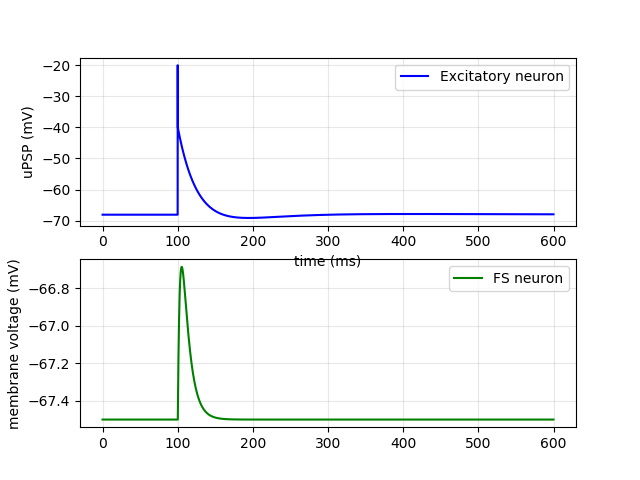

Text(0.5,0,'time (ms)')

In [19]:
fig = plt.figure()

plt.subplot(212)
plt.plot(voltage_monitor_PV.t / b2.ms,voltage_monitor_PV[0].v/b2.mV,'g',label='FS neuron')
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel('membrane voltage (mV)')
plt.subplot(211)
plt.plot(voltage_monitor_EXC.t / b2.ms,voltage_monitor_EXC[0].v/b2.mV,'b',label='Excitatory neuron')
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel('uPSP (mV)')
plt.xlabel('time (ms)')

In [20]:
# fig.savefig('../figs/25syn_fs_exc.jpg')